## Key packages
| package | Use |
| --- | --- |
| [minisom package](https://github.com/JustGlowing/minisom/blob/master/Readme.md) | Self-organizing maps (SOM) |
| [scikit-learn packages](https://scikit-learn.org/stable/index.html) | Machine learning |
| [matplotlib](https://matplotlib.org/3.1.1/index.html) | for plotting |

## Load python packages

In [15]:
# load python packages
import numpy as np
import pandas as pd
import xarray as xr
import math
import matplotlib as mpl

# load machine learning packages
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing

# minisom package for SOM
!pip install minisom
import minisom
from minisom import MiniSom

from matplotlib.patches import Patch

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
import matplotlib.cbook as cbook

### Global figure settings
This piece of code sets the font size, line widths, figure title size, and resolution for all figures generated in this cookbook.

In [11]:
# customize figure 
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams["axes.unicode_minus"] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['hatch.linewidth'] = 2.5

In [7]:
# little function
def remove_time_mean(x):
    return x - x.mean(dim='time')

# Importing data from disk

In [5]:
path='./'
dust_df = pd.read_csv(path+'saharan_dust_met_vars.csv', index_col='time')

# print out shape of data 
print('Shape of data:', np.shape(dust_df))

# print first 5 rows of data
print(dust_df.head())
feature_names = dust_df.columns
pm_df = dust_df['PM10'].values

Shape of data: (18466, 10)
                 PM10         T2        rh2         slp       PBLH  RAINC  \
time                                                                        
1960-01-01  2000.1490  288.24875  32.923786  1018.89420  484.91812    0.0   
1960-01-02  4686.5370  288.88450  30.528862  1017.26575  601.58310    0.0   
1960-01-03  5847.7515  290.97128  26.504536  1015.83514  582.38540    0.0   
1960-01-04  5252.0586  292.20060  30.678936  1013.92230  555.11860    0.0   
1960-01-05  3379.3190  293.06076  27.790462  1011.94934  394.95440    0.0   

            wind_speed_10m  wind_speed_925hPa       U10       V10  
time                                                               
1960-01-01        6.801503          13.483623 -4.671345 -4.943579  
1960-01-02        8.316340          18.027075 -6.334070 -5.388977  
1960-01-03        9.148216          17.995173 -6.701636 -6.227193  
1960-01-04        8.751743          15.806478 -6.387379 -5.982842  
1960-01-05        6.39322

In [8]:
dust_df_new =dust_df.reset_index()
dust_df_new['time'] = pd.to_datetime(dust_df_new['time'])
dust_df_final = dust_df_new.set_index('time')
dust_df_nc = dust_df_final.to_xarray()

dust_deseas = dust_df_nc.groupby('time.dayofyear').apply(remove_time_mean).to_dataframe()

# Variables exploration

Some machine learning models do not perform well when there are outliers in the data. This section explores the data for any potential outliers. The boxplots show there are outliers in the data, hence we need to use a scaling method which is robust on outliers. 

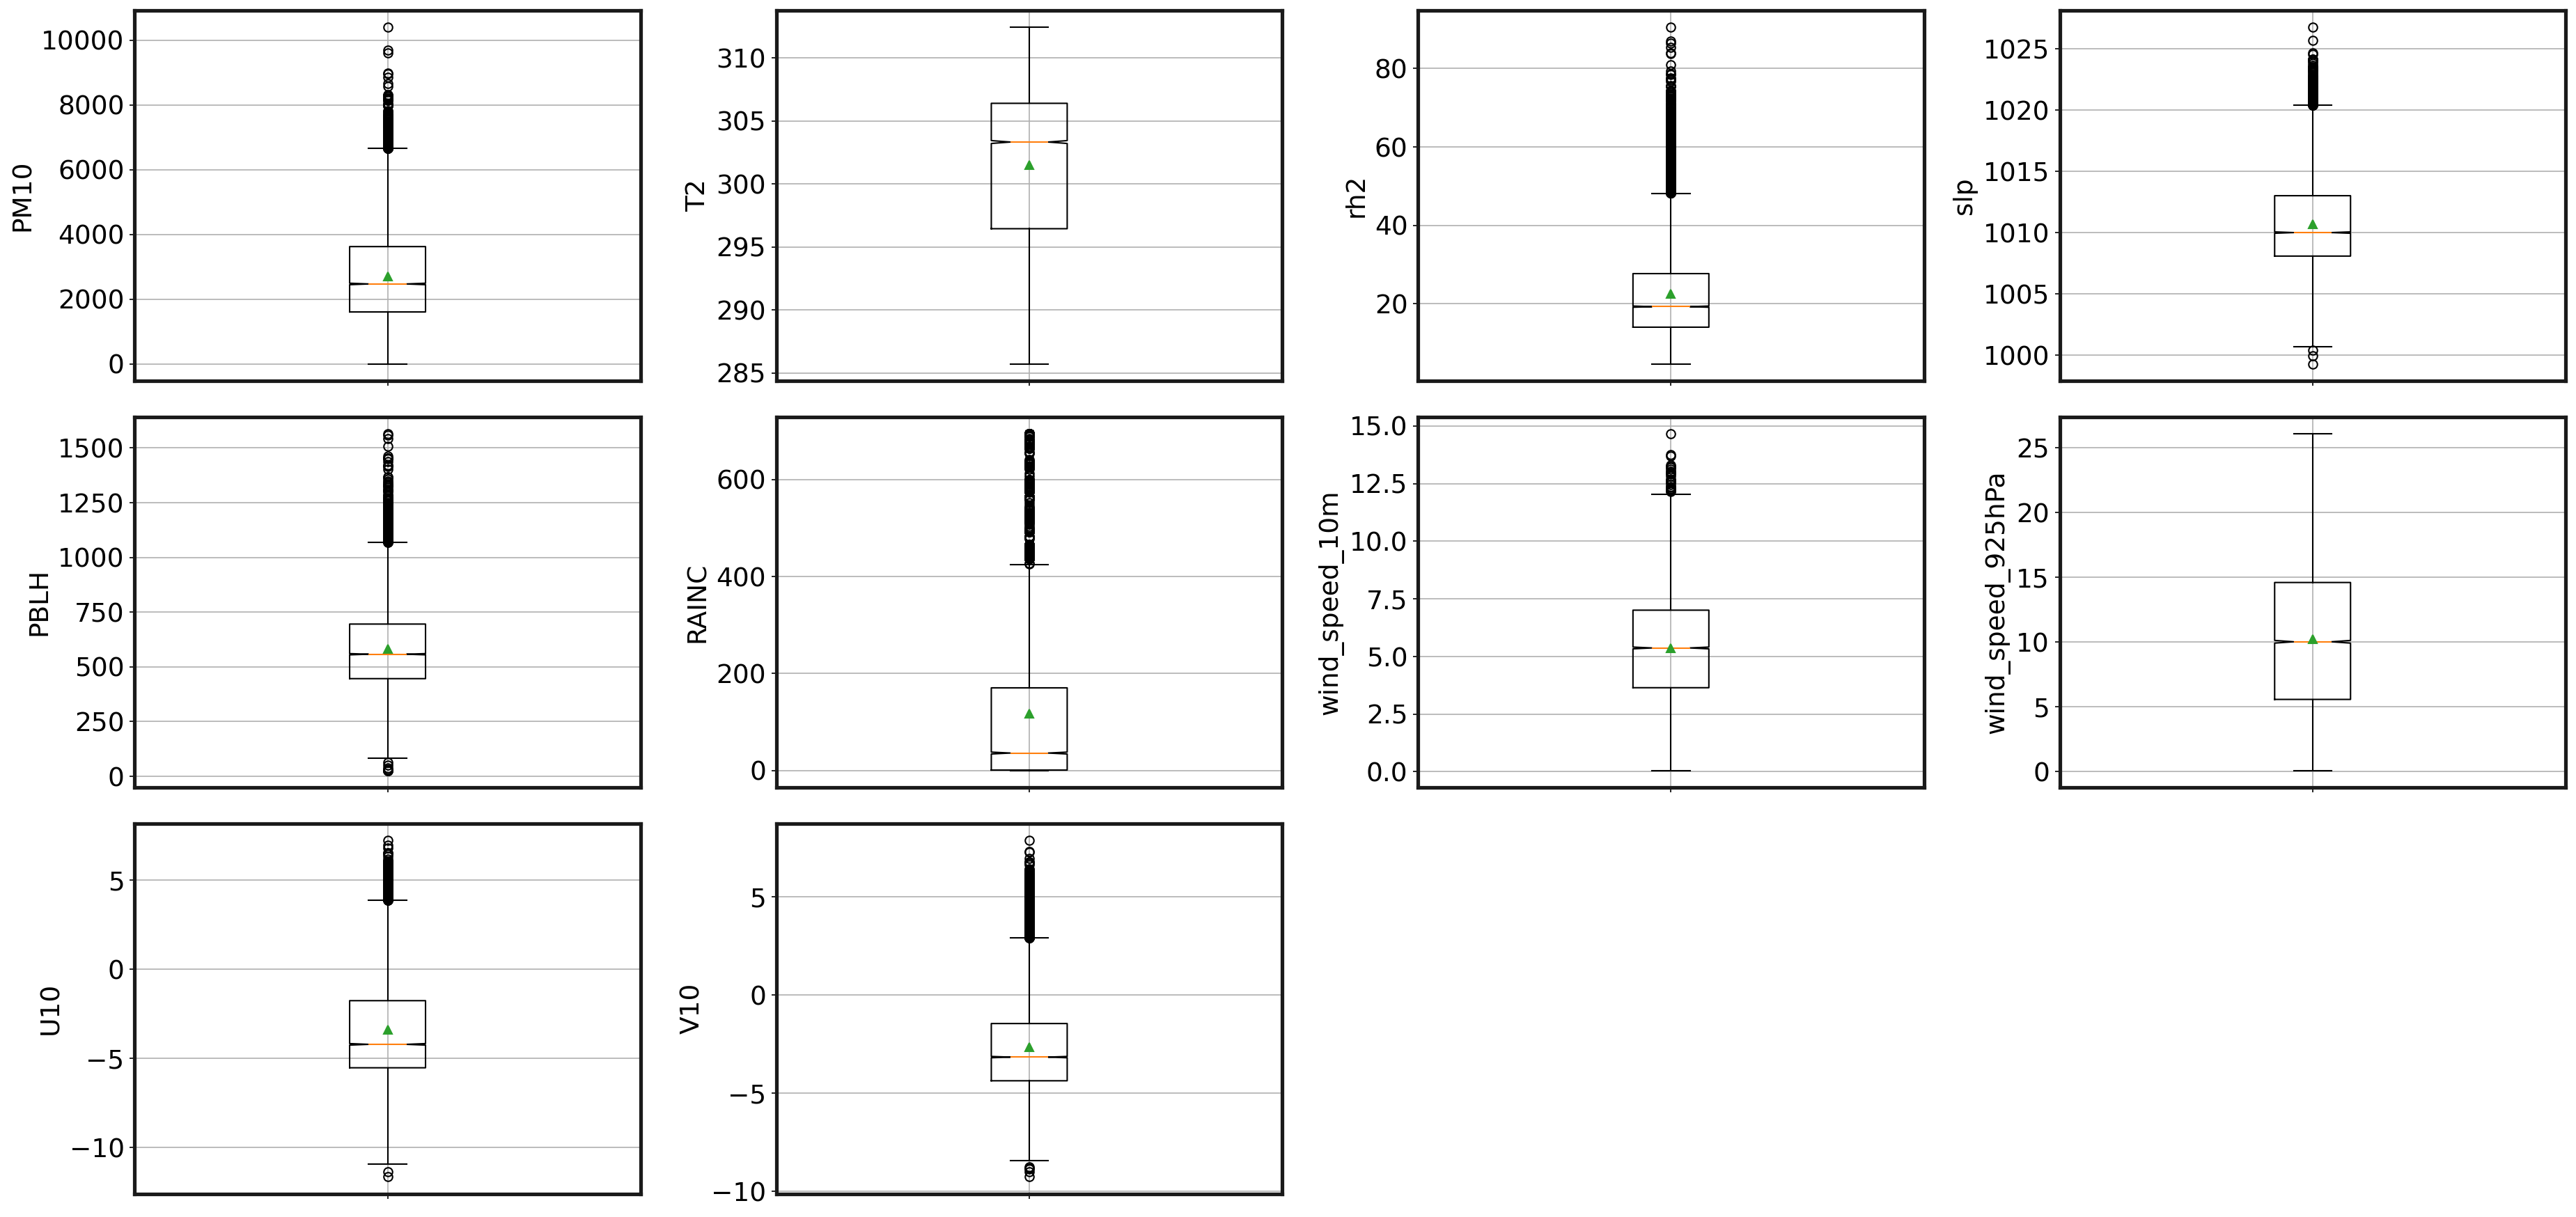

In [12]:
fig, ax = plt.subplots(3,4, figsize=(25,12))
ax = ax.flatten()
for ind, col in enumerate(feature_names):
    ax[ind].boxplot(dust_df[col].dropna(axis=0), 
                    notch=True, whis=1.5,  
                    showmeans=True)
    ax[ind].grid(which='minor', axis='both')
    ax[ind].set_xticklabels([''])
    ax[ind].set_ylabel(col)
    #ax[ind].set_title(col)
    ax[ind].set_facecolor('white')
    ax[ind].spines['bottom'].set_color('0.1')
    ax[ind].spines['top'].set_color('0.1')
    ax[ind].spines['right'].set_color('0.1')
    ax[ind].spines['left'].set_color('0.1')
    ax[ind].grid(True)
    ax[10].set_axis_off()
    ax[11].set_axis_off()
fig.tight_layout()
plt.savefig('box_plots.png')

# Scaling the variables

As you can see, there is a large range of values among variables. SOM is scale variant, so To not influence the results as it is the case in many unsupervised machine learning models, it is important to scale them. Many scaling methods exist but we will use the robust scaling method since this takes care of outliers.

In [9]:
# testing between standardization and normalization scaling 

# normalization by minmax scaling 
minmax_sc = preprocessing.MinMaxScaler(feature_range = (0, 1))
minmax_sc.fit(dust_df)
minmax_scaled_df = minmax_sc.transform(dust_df)

# standardization
std_sc = preprocessing.StandardScaler().fit(dust_df)
std_scaled_df = std_sc.transform(dust_df)

# Robust scaling for outliers
rb_sc = preprocessing.RobustScaler().fit(dust_df)
rob_scaled_df = rb_sc.transform(dust_df)

# Define map and train the SOM map

The authors of SOM recommend a map size of $$ 5\times \sqrt{(number\_of\_samples)} $$ See a full documentation of the [SOM package](https://github.com/JustGlowing/minisom/blob/master/Readme.md)

In [10]:
# training data
train_data = rob_scaled_df
# Define minisom model
n_samples = train_data.shape[1]  # retrieves the number of sampe (10 for this cookbook) 
num = math.ceil(5*math.sqrt(n_samples))
som = MiniSom(x=num,
              y=num, # map size, NxN
              input_len=10, # number of features used for training the model (10 element input vectors)
              sigma=3.,     # sigma: is the radius of the different neighbors in the SOM
              learning_rate=0.5, # learning rate: determines how much the weights are adjusted during each iterations
              neighborhood_function='gaussian', # a few options for this
             topology='hexagonal', 
              activation_distance='euclidean', 
              random_seed=10)

# initilize weight
som.random_weights_init(train_data)  # random weights initialization 
#som.pca_weights_init(train_data)  # initialize weights using PCA 

## there are two type of training
# 1. train_random: trains model by pickinhg random data from the data
# 2. train_batch: trains model from samples in the order in which they are fed.

som.train(data = train_data, num_iteration = 25000, 
          verbose=True, random_order=True) # training the SOM model for 25000 iterations 

 [ 25000 / 25000 ] 100% - 0:00:00 left 
 quantization error: 0.7955823980825105


# Visualizing the SOM results

## Neighbour distance 

The neighbor distance is also known as the “U-Matrix”. It is the distance between each node and its neighbours. Regions of low neighbourhood distance indicate groups of nodes that are similar, while regions of large distances indicate nodes are much more different. The U-Matrix can be used to identify clusters within the SOM map.

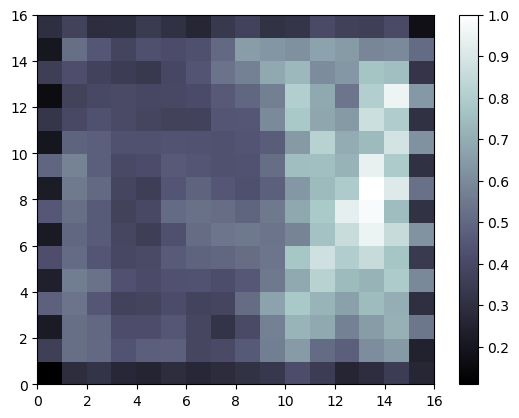

In [16]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T, cmap='bone')
colorbar()

markers = ['o', 's']
colors = ['r', 'g']

# for i, x in enumerate(minmax_scaled_df):
#     #print(i)
#     w = som.winner(x)
#     plot(w[0]+0.5,
#          w[1]+0.5,
#          markers[pm_loc[i]],
#          markeredgecolor = colors[pm_loc[i]],
#          markerfacecolor = 'None',
#          markersize=10,
#          markeredgewidth=2)

## Feature plane


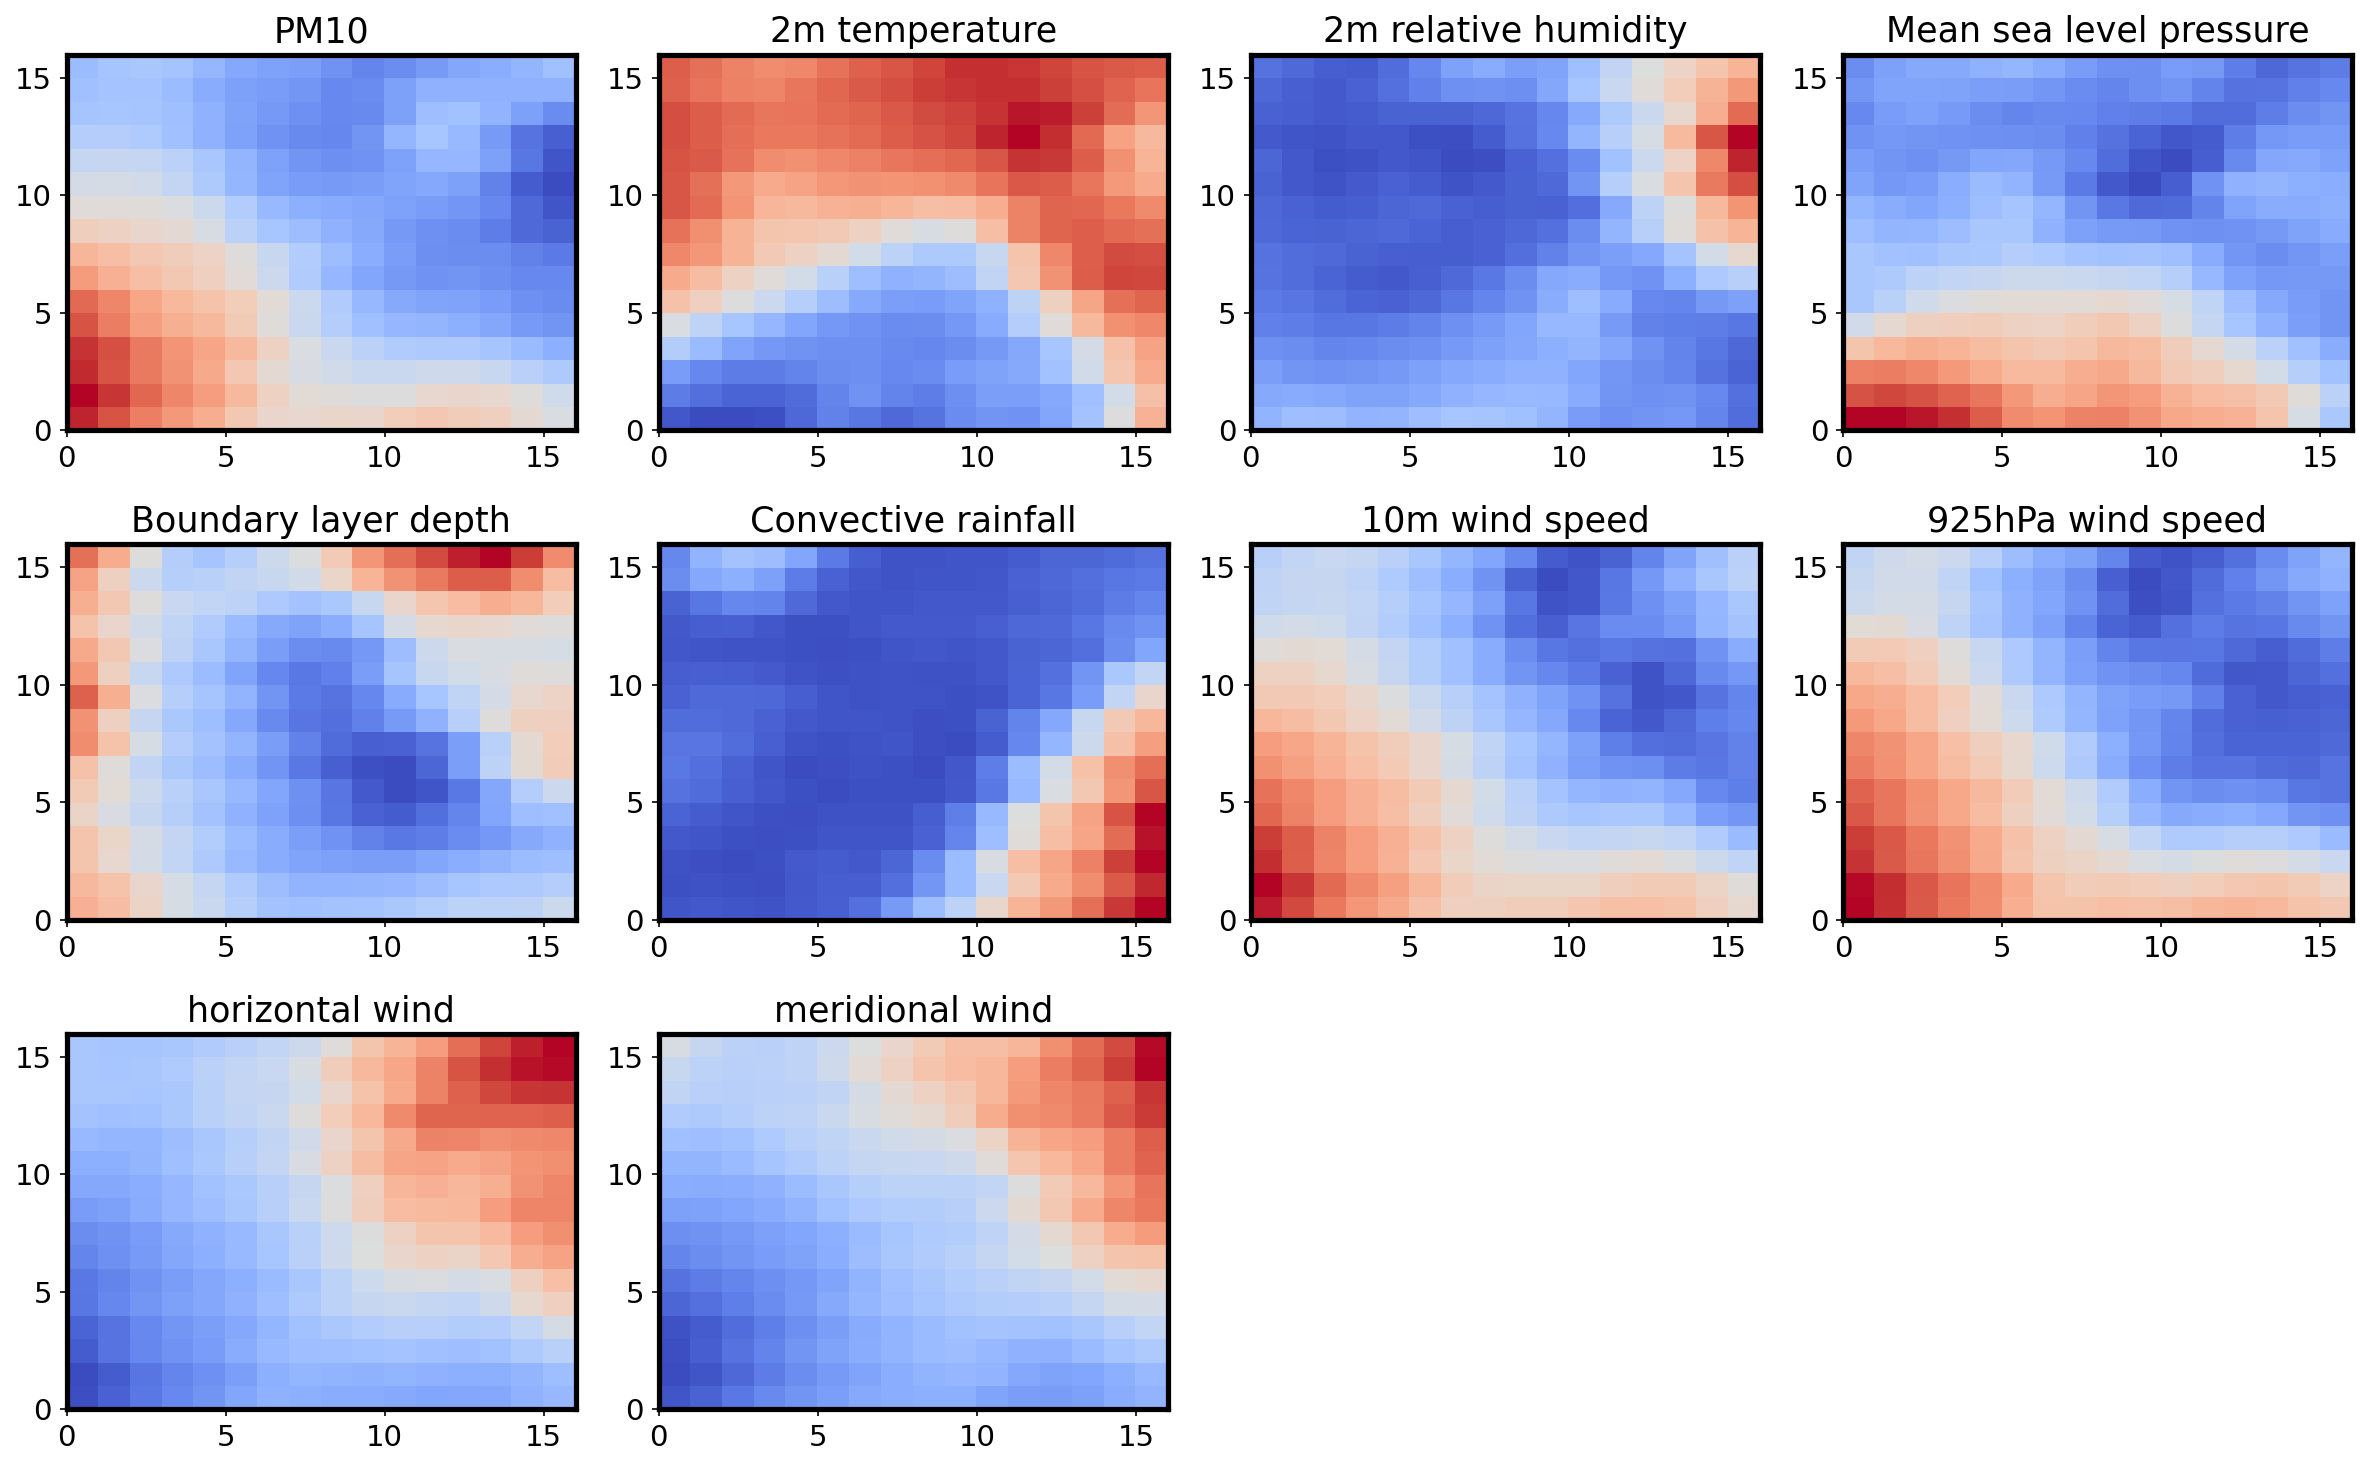

In [20]:
titles = ['PM10', '2m temperature', '2m relative humidity', 'Mean sea level pressure', 'Boundary layer depth', 
          'Convective rainfall', '10m wind speed', '925hPa wind speed', 'horizontal wind', 'meridional wind']
W = som.get_weights()
fig, ax = plt.subplots(3, 4, figsize=(16, 10))
ax = ax.flatten()
for i, f in enumerate(feature_names):
    #plt.subplot(5, 2, i+1)
    ax[i].set_title(titles[i])
    ax[i].pcolor(W[:,:,i].T, cmap='coolwarm')
    #ax[i].set_xticks(np.arange(num+1))
    #ax[i].set_yticks(np.arange(num+1))
ax[10].set_axis_off()
ax[11].set_axis_off()
plt.tight_layout()
plt.savefig('feature_patterns.png')

## Most relevant feature plane



In [ ]:
# cols = np.array(['sandybrown', 'red', 'darkgreen', 'steelblue', 'magenta', 'lighseagreen', 'blue', 'slateblue', 'orange',
#                'darkorange'])
Z = np.zeros((num, num))
plt.figure(figsize=(16, 10))
for i in np.arange(som._weights.shape[0]):
    for j in np.arange(som._weights.shape[1]):
        feature = np.argmax(W[i, j , :])
        plt.plot([i+.5], [j+.5], color='C'+str(feature),
                 marker='o', markersize=24)

legend_elements = [Patch(facecolor='C'+str(i),
                         edgecolor='w',
                         label=f) for i, f in enumerate(feature_names)]

plt.legend(handles=legend_elements,
           loc='center left',
           bbox_to_anchor=(1, .75))
        
plt.xlim([0, num])
plt.ylim([0, num])
plt.savefig('feature_importance.png')
plt.show()

# Random Forest Regression

In [19]:
# Load packages
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Define a function for error calculations

In [20]:
def regression_stats(model_fit, model_name, features_test, pred, target_test):
  #Calculate and display model error
  score = model_fit.score(features_test,target_test)
  print('\n'+model_name)
  print(f'Score : {score}')
  print(f'MAE: {mean_absolute_error(pred,target_test)}')
  print(f'RMSE : {np.sqrt(mean_squared_error(pred,target_test))}')

In [21]:
target_vars = dust_df['PM10']   # PM10 concentration is the target variable
features = dust_df.drop(['PM10'], axis=1)  # remaining variables should be features

# split the data into 70% training and reserve 30% for testing
train_features, test_features, train_target, test_target = train_test_split(features, 
                                                                target_vars, test_size = 0.3)

# Now train the model using the training sets
rf = RandomForestRegressor(n_estimators=200,
                    random_state=42, n_jobs=-1)
# Fit Random forest model
rf.fit(train_features, train_target)
predictions = rf.predict(test_features)

regression_stats(rf,'Random Forest',test_features, predictions, test_target)


Random Forest
Score : 0.9097126757264253
MAE: 298.1974527094828
RMSE : 423.72012922539517


# Variable importance

In [22]:
# customize figure 
import matplotlib as mpl
mpl.rcParams['font.size'] = 28
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams["axes.unicode_minus"] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['hatch.linewidth'] = 2.5

In [ ]:
col_names = list(features.columns)
cols = np.array(['red', 'blue', 'green', 'cyan', 'pink', 'olive', 'purple', 'magenta',
                'indigo'])

fig, ax = plt.subplots(1,1, figsize=(22,14), sharex=False, sharey=False, 
                               constrained_layout=True) 

sorted_idx = rf.feature_importances_.argsort()
importances = rf.feature_importances_
x_values = col_names

# Make a bar chart
ax.barh(features.columns[sorted_idx], 
           importances[sorted_idx], color=cols)

ax.set_xlabel('Random Forest Feature Importance')     
ax.set_ylabel('Features')

Text(0, 0.5, 'Features')

# Hyper-parameter tuning?